# Forecast with a Deep Learning Network.
**Goal: Make a deep learning network similar to my [Bike-Sharing-Prediction project](https://github.com/viktor-begun/Deep_Learning_Bike_Sharing) and use it to forecast the price movement.**  

##  Load and prepare the data 

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data_path = 'EURUSD_1H_2016.txt'
df = pd.read_table(data_path,sep=',')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8783 entries, 0 to 8782
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Local time  8783 non-null   object 
 1   Open        8783 non-null   float64
 2   High        8783 non-null   float64
 3   Low         8783 non-null   float64
 4   Close       8783 non-null   float64
 5   Volume      8783 non-null   float64
dtypes: float64(5), object(1)
memory usage: 411.8+ KB


In [4]:
df.head()

,Local time,Open,High,Low,Close,Volume
0,01.01.2016 00:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
1,01.01.2016 01:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
2,01.01.2016 02:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
3,01.01.2016 03:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0
4,01.01.2016 04:00:00.000,1.08564,1.08564,1.08564,1.08564,0.0


**(!) Exclude non-trading hours.**

In [25]:
df = df[df.Volume!=0]
df.reset_index(inplace=True)
df

,index,Local time,Open,High,Low,Close,Volume,HML
0,62,03.01.2016 14:00:00.000,1.08730,1.08730,1.08659,1.08666,1485.9301,0.00071
1,63,03.01.2016 15:00:00.000,1.08665,1.08665,1.08451,1.08516,4071.6499,0.00214
2,64,03.01.2016 16:00:00.000,1.08515,1.08577,1.08431,1.08453,4182.2402,0.00146
3,65,03.01.2016 17:00:00.000,1.08453,1.08616,1.08272,1.08599,6970.7100,0.00344
4,66,03.01.2016 18:00:00.000,1.08597,1.08756,1.08582,1.08714,6419.8901,0.00174
...,...,...,...,...,...,...,...,...
6234,8744,30.12.2016 09:00:00.000,1.05517,1.05542,1.05290,1.05462,8413.1602,0.00252
6235,8745,30.12.2016 10:00:00.000,1.05467,1.05475,1.05254,1.05271,9148.3096,0.00221
6236,8746,30.12.2016 11:00:00.000,1.05269,1.05360,1.05232,1.05343,7321.8501,0.00128
6237,8747,30.12.2016 12:00:00.000,1.05347,1.05376,1.05238,1.05247,6416.3398,0.00138


In [26]:
df.Low

0       1.08659
1       1.08451
2       1.08431
3       1.08272
4       1.08582
         ...   
6234    1.05290
6235    1.05254
6236    1.05232
6237    1.05238
6238    1.05123
Name: Low, Length: 6239, dtype: float64

**(!) Add a new column `High` minus `Low` - [`HML`](https://www.investopedia.com/terms/h/high_minus_low.asp)**

In [27]:
df['HML'] = df.High - df.Low

In [28]:
df.head()

,index,Local time,Open,High,Low,Close,Volume,HML
0,62,03.01.2016 14:00:00.000,1.08730,1.08730,1.08659,1.08666,1485.9301,0.00071
1,63,03.01.2016 15:00:00.000,1.08665,1.08665,1.08451,1.08516,4071.6499,0.00214
2,64,03.01.2016 16:00:00.000,1.08515,1.08577,1.08431,1.08453,4182.2402,0.00146
3,65,03.01.2016 17:00:00.000,1.08453,1.08616,1.08272,1.08599,6970.7100,0.00344
4,66,03.01.2016 18:00:00.000,1.08597,1.08756,1.08582,1.08714,6419.8901,0.00174


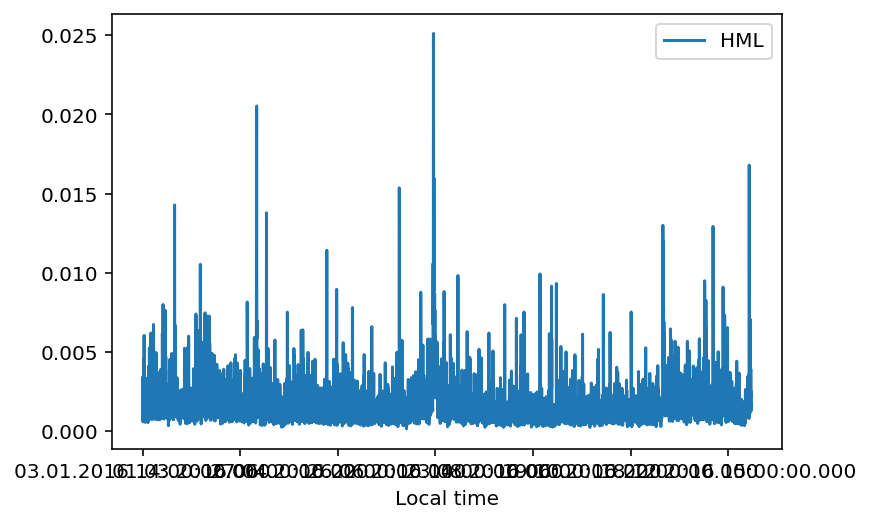

In [29]:
df.plot(x='Local time', y='HML');

## Dummy variables
We do not have dummy variables yet, but **we drop the `Local time`**, because it is a string, while our Neural Network accepts only numbers. It should be ok, because we keep the index, which can be used later to reconstruct the date and time. 

In [30]:
#dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
#for each in dummy_fields:
#    dummies = pd.get_dummies(rides[each], prefix=each, drop_first=False)
#    rides = pd.concat([rides, dummies], axis=1)

fields_to_drop = ['Local time']
df_no_time = df.drop(fields_to_drop, axis=1)
df_no_time.head()

,index,Open,High,Low,Close,Volume,HML
0,62,1.08730,1.08730,1.08659,1.08666,1485.9301,0.00071
1,63,1.08665,1.08665,1.08451,1.08516,4071.6499,0.00214
2,64,1.08515,1.08577,1.08431,1.08453,4182.2402,0.00146
3,65,1.08453,1.08616,1.08272,1.08599,6970.7100,0.00344
4,66,1.08597,1.08756,1.08582,1.08714,6419.8901,0.00174


## Scaling target variables
To make training the network easier, we'll standardize each of the continuous variables. That is, we'll shift and scale the variables such that they have zero mean and a standard deviation of 1.

The scaling factors are saved so we can go backwards when we use the network for predictions.

In [31]:
quant_features = ['Open', 'High', 'Low', 'Close', 'Volume', 'HML']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = df_no_time[each].mean(), df_no_time[each].std()
    scaled_features[each] = [mean, std]
    df_no_time.loc[:, each] = (df_no_time[each] - mean)/std

df_no_time.head()

,index,Open,High,Low,Close,Volume,HML
0,62,-0.784208,-0.819799,-0.779739,-0.809558,-0.924837,-0.684683
1,63,-0.810196,-0.845833,-0.862768,-0.869517,-0.788555,0.362897
2,64,-0.870170,-0.881079,-0.870751,-0.894700,-0.782726,-0.135253
3,65,-0.894959,-0.865458,-0.934221,-0.836340,-0.635758,1.315241
4,66,-0.837385,-0.809385,-0.810476,-0.790371,-0.664789,0.069867


## Splitting the data into training, testing, and validation sets.

We'll save the data for the last approximately 21 days to use as a test set after we've trained the network. We'll use this set to make predictions and compare them with the actual values.

In [32]:
# Save data for approximately the last 21 days 
test_df = df_no_time[-21*24:]

# Now remove the test data from the data set 
df_no_time = df_no_time[:-21*24]

# Separate the data into features and targets
target_fields = ['HML', 'Volume']
features, targets = df_no_time.drop(target_fields, axis=1), df_no_time[target_fields]
test_features, test_targets = test_df.drop(target_fields, axis=1), test_df[target_fields]

In [33]:
targets.head()

,HML,Volume
0,-0.684683,-0.924837
1,0.362897,-0.788555
2,-0.135253,-0.782726
3,1.315241,-0.635758
4,0.069867,-0.664789


In [34]:
features.head()

,index,Open,High,Low,Close
0,62,-0.784208,-0.819799,-0.779739,-0.809558
1,63,-0.810196,-0.845833,-0.862768,-0.869517
2,64,-0.870170,-0.881079,-0.870751,-0.894700
3,65,-0.894959,-0.865458,-0.934221,-0.836340
4,66,-0.837385,-0.809385,-0.810476,-0.790371


In [35]:
# Hold out the last 60 days or so of the remaining data as a validation set
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [36]:
targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5735 entries, 0 to 5734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HML     5735 non-null   float64
 1   Volume  5735 non-null   float64
dtypes: float64(2)
memory usage: 89.7 KB


In [37]:
val_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 4295 to 5734
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   HML     1440 non-null   float64
 1   Volume  1440 non-null   float64
dtypes: float64(2)
memory usage: 22.6 KB


In [38]:
from DL_Forecast_Network import NeuralNetwork

In [39]:
def MSE(y, Y):
    return np.mean((y-Y)**2)

## Unit tests
Run these unit tests to check the correctness of your network implementation. This will help you be sure your network was implemented correctly befor you starting trying to train it. These tests must all be successful to pass the project.

In [40]:
import unittest

inputs = np.array([[0.5, -0.2, 0.1]])
targets = np.array([[0.4]])
test_w_i_h = np.array([[0.1, -0.2],
                       [0.4, 0.5],
                       [-0.3, 0.2]])
test_w_h_o = np.array([[0.3],
                       [-0.1]])

class TestMethods(unittest.TestCase):
    
    ##########
    # Unit tests for data loading
    ##########
    
    def test_data_path(self):
        # Test that file path to dataset has been unaltered
        self.assertTrue(data_path.lower() == 'eurusd_1h_2016.txt') #'bike-sharing-dataset/hour.csv')
        
    def test_data_loaded(self):
        # Test that data frame loaded
        self.assertTrue(isinstance(df, pd.DataFrame))
    
    ##########
    # Unit tests for network functionality
    ##########

    def test_activation(self):
        network = NeuralNetwork(3, 2, 1, 0.5)
        # Test that the activation function is a sigmoid
        self.assertTrue(np.all(network.activation_function(0.5) == 1/(1+np.exp(-0.5))))

    def test_train(self):
        # Test that weights are updated correctly on training
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()
        
        network.train(inputs, targets)
        self.assertTrue(np.allclose(network.weights_hidden_to_output, 
                                    np.array([[ 0.37275328], 
                                              [-0.03172939]])))
        self.assertTrue(np.allclose(network.weights_input_to_hidden,
                                    np.array([[ 0.10562014, -0.20185996], 
                                              [0.39775194, 0.50074398], 
                                              [-0.29887597, 0.19962801]])))

    def test_run(self):
        # Test correctness of run method
        network = NeuralNetwork(3, 2, 1, 0.5)
        network.weights_input_to_hidden = test_w_i_h.copy()
        network.weights_hidden_to_output = test_w_h_o.copy()

        self.assertTrue(np.allclose(network.run(inputs), 0.09998924))

suite = unittest.TestLoader().loadTestsFromModule(TestMethods())
unittest.TextTestRunner().run(suite)


.....
----------------------------------------------------------------------
Ran 5 tests in 0.013s

OK


<unittest.runner.TextTestResult run=5 errors=0 failures=0>

## Training the network

In [58]:
#batch = np.random.choice(train_features.index, size=128)
#X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['HML']
#print(X,y)

In [59]:
import sys

####################
### Set the hyperparameters in you myanswers.py file ###
####################

#from my_answers import iterations, learning_rate, hidden_nodes, output_nodes
from DL_Forecast_Network import iterations, learning_rate, hidden_nodes, output_nodes


N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for ii in range(iterations):
    # Go through a random batch of 128 records from the training data set
    batch = np.random.choice(train_features.index, size=128)
    X, y = train_features.iloc[batch].values, train_targets.iloc[batch]['HML']
                             
    network.train(X, y)
    
    # Printing out the training progress
    train_loss = MSE(network.run(train_features).T, train_targets['HML'].values)
    val_loss = MSE(network.run(val_features).T, val_targets['HML'].values)
    sys.stdout.write("\rProgress: {:2.1f}".format(100 * ii/float(iterations)) \
                     + "% ... Training loss: " + str(train_loss)[:5] \
                     + " ... Validation loss: " + str(val_loss)[:5])
    sys.stdout.flush()
    
    losses['train'].append(train_loss)
    losses['validation'].append(val_loss)

Progress: 0.1% ... Training loss: 19169 ... Validation loss: 19173

/home/vb/Programming/ML_Trading/DL_Forecast_Network.py:23: RuntimeWarning: overflow encountered in exp
  self.activation_function = lambda x : 1 / (1+np.exp(-x))  # Replace 0 with your sigmoid calculation.


Progress: 100.0% ... Training loss: 1.060 ... Validation loss: 0.698

iterations = 4000 learning_rate = 0.4 hidden_nodes = 20 output_nodes = 1
Training loss = 1.0606200134094041 
Validation loss = 0.6986746379243974


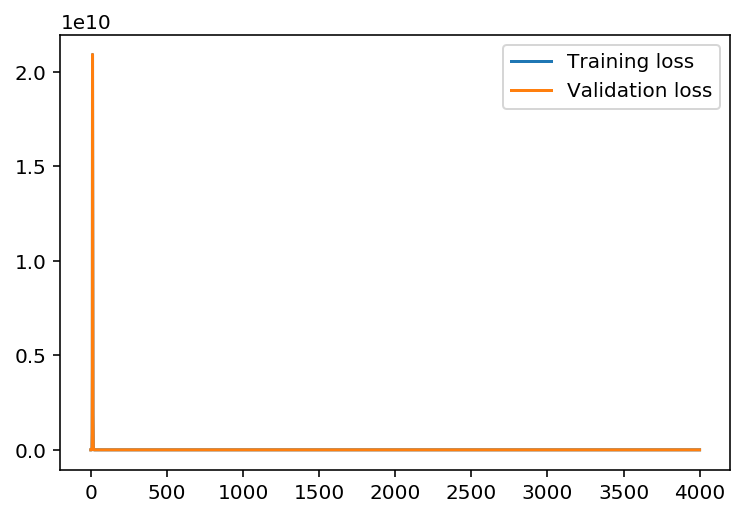

In [60]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()
_ = plt.ylim()
print('Training loss =',losses['train'][-1],'\nValidation loss =',losses['validation'][-1])

## Check out the predictions

iterations = 4000 learning_rate = 0.4 hidden_nodes = 20 output_nodes = 1


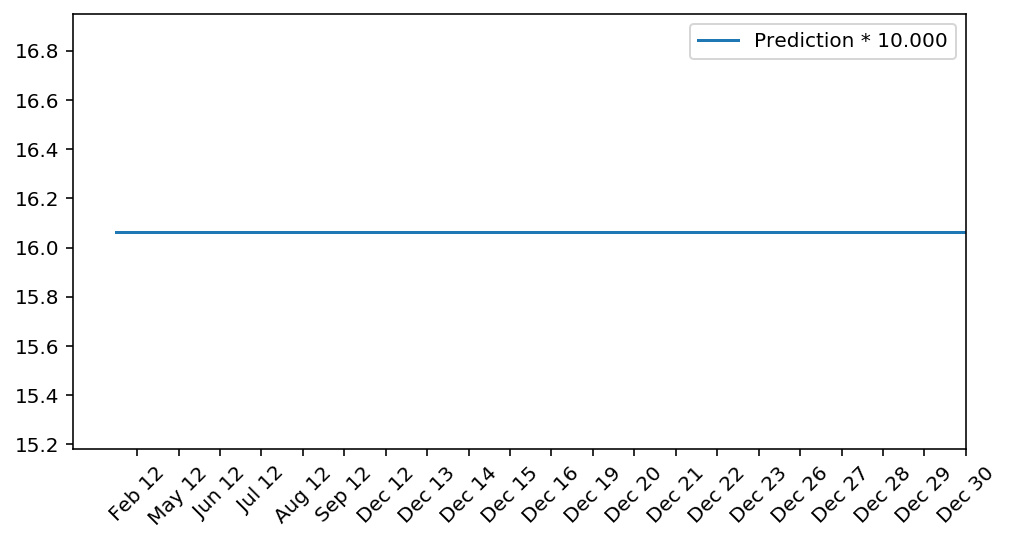

In [61]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['HML']
predictions = network.run(test_features).T*std + mean
#ax.plot(predictions[0], label='Prediction')
#ax.plot((test_targets['HML']*std + mean).values, label='Data')
#
f1 = predictions[0]
f2 = (test_targets['HML']*std + mean).values
diff = 100*(f1 - f2) / f2
ax.plot(f1*10000, label='Prediction * 10.000')
#ax.plot(f2*1000, label='Data * 1.000')
#ax.plot(diff, label='( Prediction - Data ) / Data, [%]')
#

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_df.index]['Local time'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

**=============================**

iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1


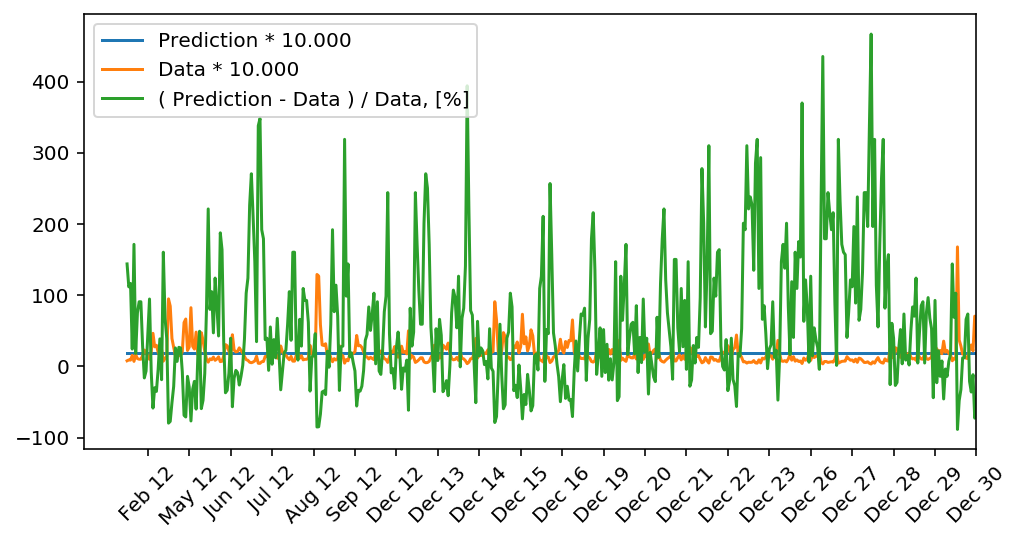

In [44]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['HML']
predictions = network.run(test_features).T*std + mean
#ax.plot(predictions[0], label='Prediction')
#ax.plot((test_targets['HML']*std + mean).values, label='Data')
#
f1 = predictions[0]
f2 = (test_targets['HML']*std + mean).values
diff = 100*(f1 - f2) / f2
ax.plot(f1*10000, label='Prediction * 10.000')
ax.plot(f2*10000, label='Data * 10.000')
ax.plot(diff, label='( Prediction - Data ) / Data, [%]')
#

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_df.index]['Local time'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

**(!) The model is not learning with `iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1` without non-trading hours! Why?**

**(!) Below is the result with non-trading hours.**

iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1


/home/vb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


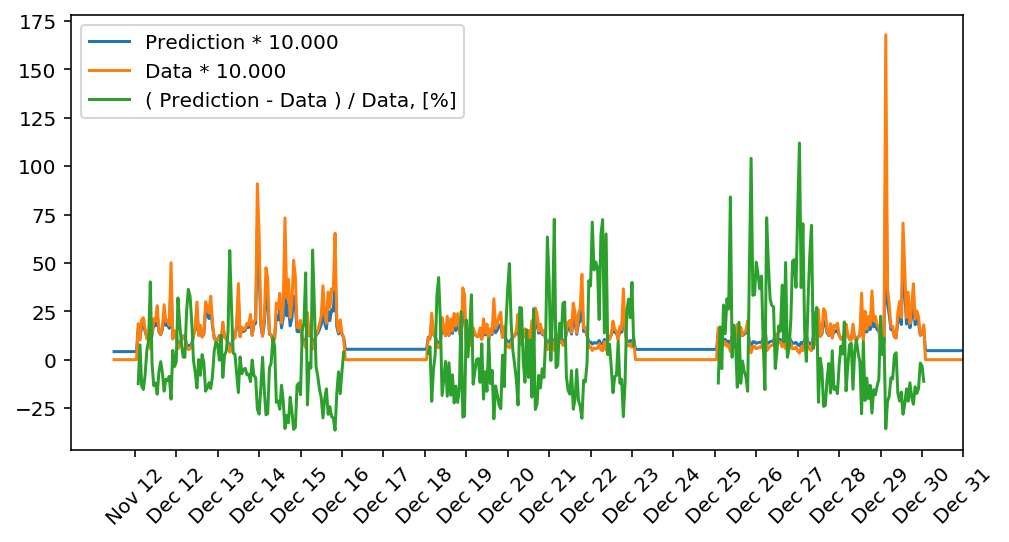

In [26]:
print('iterations =',iterations,'learning_rate =',learning_rate,'hidden_nodes =',hidden_nodes,'output_nodes =',output_nodes)

fig, ax = plt.subplots(figsize=(8,4))

mean, std = scaled_features['HML']
predictions = network.run(test_features).T*std + mean
#ax.plot(predictions[0], label='Prediction')
#ax.plot((test_targets['HML']*std + mean).values, label='Data')
#
f1 = predictions[0]
f2 = (test_targets['HML']*std + mean).values
diff = 100*(f1 - f2) / f2
ax.plot(f1*10000, label='Prediction * 10.000')
ax.plot(f2*10000, label='Data * 10.000')
ax.plot(diff, label='( Prediction - Data ) / Data, [%]')
#

ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(df.iloc[test_df.index]['Local time'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)

**(!) The prediction for `iterations = 10000 learning_rate = 0.3 hidden_nodes = 30 output_nodes = 1` can have an error from `-25%` to `100%`.**